In [4]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import numpy as np

%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))


## DMS Data

In [9]:
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

## Dask with gateway

In [3]:
from dask.distributed import Client
from dask_gateway import Gateway
gateway = Gateway()

In [4]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)
cluster.scale(8)
client = Client(cluster) # create a dask Gateway cluster
cluster

In [5]:
if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.d9fb6d6b87974c60afe8b37b1053b0d8/status,


In [4]:
#closing open 
# clusters=gateway.list_clusters()
# print(clusters )
# for cluster in clusters :
#     cluster= gateway.connect(cluster.name)
#     print(cluster)
#     client = Client(cluster)
#     client.close()
#     cluster.shutdown()

In [6]:
# To close at end of session
client.close()

In [7]:
cluster.shutdown()

## Open files

In [7]:
#### single file
file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_S2004_8D_28km.nc'
ds = xr.open_dataset(s3.open(file)).squeeze()

### multiple files
# s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
# remote_files = s3.glob(s3files)
# fileset = [s3.open(file) for file in remote_files]
# ds = xr.open_mfdataset(fileset, combine='by_coords')
# remove dependence of lat and long on year
# ds['latitude'] = ds.latitude.isel(year=0)
# ds['longitude'] = ds.longitude.isel(year=0)

ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, period: 46)
Coordinates:
    year         float64 2.01e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (pixel) float64 ...
    latitude     (pixel) float64 ...
    startjulday  (period) float64 ...
    endjulday    (period) float64 ...
    dms          (period, pixel) float64 ...

## Selecting area

In [8]:
ds = ds.where(
    (ds.longitude>=-10) & (ds.longitude<=10) & 
    (ds.latitude <=85 ) & (ds.latitude >= 70),
    drop = True)
ds

<xarray.Dataset>
Dimensions:      (pixel: 1033, period: 46)
Coordinates:
    year         float64 2.01e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (pixel) float64 -9.918 -9.184 -8.449 ... 2.791 5.581 8.372
    latitude     (pixel) float64 70.12 70.12 70.12 70.12 ... 84.88 84.88 84.88
    startjulday  (period, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (period, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (period, pixel) float64 nan nan nan nan nan ... nan nan nan nan

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


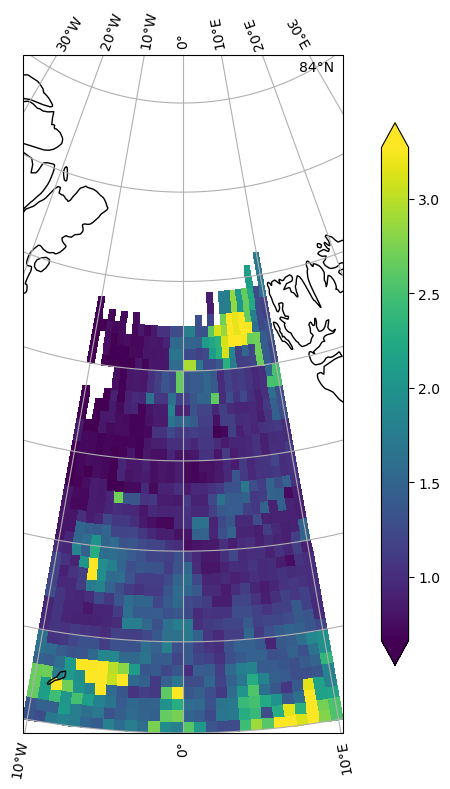

In [16]:
import functions as f

dms_gridded = f.interGali(ds.isel(period=30), 'dms')
f.pltNPS(dms_gridded)